# **NN**

### **Objetivo:** Implementar **Random Search** y a su mejor resultado aplicar **Grid Search** en una arquitectura NN.

**Descripción:** consiste en realizar una búsqueda aleatoria de hiperparametros, y luego en base a los conjuntos de hiperparametros que mejor hayan preformado, realizar una búsqueda exhaustiva usando GridSearch. 

De esta manera, se muestrea mayor cantidad de valores para los hiperparametros más importantes, y por otro lado se hace una búsqueda en detalle más localizada, logrando ahorros en costo computacional y sobretodo en tiempo.

<img src="imagenes/busquedas.png" alt="Retícula generada" width="600"/>


#### **1 - Random Search:**

Dominio *Learning rate* inicial = [0.1, 0.0001]

Dominio épocas = [1, 100] 

<img src="imagenes/reticula_random.jpg" alt="Retícula generada" width="400"/>

Los puntos utilizados son:

| Punto | épocas | *learning rate* inicial |
|-------|--------|-------------------------|
| I     |   5    |         0,1             |
| II    |   10   |         0,01            |
| III   |   20   |         0,005           |
| IV    |   12   |         0,001           |
| V     |   14   |         0,0005          |
| VI    |   8    |         0,003           |
| VII   |   6    |         0,007           |
| VIII  |   4    |         0,002           |
| IX    |   15   |         0,0006          |
| X     |   18   |         0,0003          |
| XI    |   9    |         0,0004          |
| XII   |   2    |         0.008           |
| XIII  |   30   |         0,0002          |
| XIV   |   25   |         0,02            |
| X     |   22   |         0.006           |

#### Características de la NN:

**Variables:**
1. componente zonal del viento (u)
2. Componente meridional del viento (v)
3. temperatura (temp)
4. altura geopotencial (alt_geop)

**Entrada:** Datos de reanálisis. Corresponde al tiempo *t.*
- longitud, latitud, u, v, temperatura y altura geopotencial

**Salida:** Inferencias, correspondientes al tiempo *t + 6hs.*
- u, v, temperatura y altura geopotencial

**Función de pérdida (MSE):**
1. Pérdida de datos etiquetados de las variables de salida, comparando el reanálisis y la inferenicia correspondientes a *t + 6 hs.*
2. Pérdida de datos etiquetados de las variables de salida, comparando el reanálisis y la inferenicia correspondientes a *t + 12 hs.*

**Normalizaciones:**
- Variables físicas por media/desvío estándar (M=0, SD=1).
- Variables espaciales por mínimo/máximo [0, 1].

**Hiperparámetros del modelo:**
- Tres capas en total, una oculta con 12 neuronas.
- Función de activación: tangente hiperbólica. Dominio (-inf, inf). Rango (-1, 1).
- Learning rate:
  - *Cosine learning-rate schedule* hasta 0,0001
- Épocas

In [1]:
# Instala librerías necesarias
!apt-get install -y libeccodes-data libeccodes-dev
!pip install torch torchvision torchaudio scipy
!pip install matplotlib pandas openpyxl seaborn 

"apt-get" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.



[notice] A new release of pip is available: 24.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Importa las librerias necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import os
import gc
import openpyxl
import seaborn as sns
from scipy.interpolate import griddata

import torch
import torch.nn as nn
import torch.fft
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn.functional as F

In [3]:
# Definir y verificar el dispositvo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("¿PyTorch detecta CUDA?:", torch.cuda.is_available())
print("Versión de CUDA en PyTorch:", torch.version.cuda)
print("GPU detectada:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "Ninguna")

¿PyTorch detecta CUDA?: True
Versión de CUDA en PyTorch: 12.1
GPU detectada: NVIDIA GeForce RTX 3060


In [4]:
# Define las rutas a los archivos
"""
1: Geopotential: m**2 s**-2 (instant): isobaricInhPa: level 500: fcst time 0 hrs
2: Temperature: K (instant): isobaricInhPa :level 500: fcst time 0 hrs
3: U component of wind: m s**-1 (instant): isobaricInhPa: level 500: fcst time 0 hrs
4: V component of wind: m s**-1 (instant): isobaricInhPa: level 500: fcst time 0 hrs

Continua con 06Z, 12Z y 18Z respestando el orden.
"""
ruta_notebook = os.getcwd()
ruta_dir_padre = os.path.dirname(ruta_notebook)
ruta_files = ruta_dir_padre + '/files/'

filename_train = ruta_files + '200401201501.nc'
filename_val = ruta_files + '201601.nc'

In [5]:
# Cargar datos desde GRIB
def load_nc_data(filename):
    # Abre el archivo
    ds = Dataset(filename, mode='r')
    #print(ds.variables)
    
    # Selecciona las variables de interés
    alt_geop = ds.variables['z'][:].squeeze()        # Altura del geopotencial [m^2*s^-2]
    u = ds.variables['u'][:].squeeze()               # Componente zonal del viento [m/s]
    v = ds.variables['v'][:].squeeze()               # Componente meridional del viento [m/s]
    temp = ds.variables['t'][:].squeeze()            # Temperatura [K]
    lat = ds.variables['latitude'][:]                # Latitud [º Norte]
    lon = ds.variables['longitude'][:]               # Longitud [º Este]

    # Crear la retícula de puntos equiespaciaods
    lons, lats = np.meshgrid(lon, lat)

    # Extraer los valores para todos los tiempos: (Tiempo, Latitud, Longitud) - Convertir a Array
    alt_geop = np.array(alt_geop)
    temp = np.array(temp)
    u = np.array(u)
    v = np.array(v)
    lons = np.array(lons)
    lats = np.array(lats)

    return lons, lats, u, v, temp, alt_geop

In [6]:
# Función para normalización Min-Max
def min_max_normalize(data):
    data_min = np.min(data)
    data_max = np.max(data)

    if data_max == data_min:
        return np.zeros_like(data)  # Evita divisiones por cero en caso de valores constantes

    return (data - data_min) / (data_max - data_min)

In [7]:
# Función para normalización z-score de datos de entrenamiento
def z_score_train_normalize(data):
    mean = np.mean(data)
    std = np.std(data)

    if std == 0:
        return np.zeros_like(data)  # Evita divisiones por cero si los datos son constantes

    return mean, std, (data - mean) / std

In [8]:
# Función para normalización z-score
def z_score_normalize(data, mean, std):

    return (data - mean) / std

In [9]:
class NN(nn.Module):
    def __init__(self, hidden_size=12, num_hidden_layers=1):
        super(NN, self).__init__()
        layers = []

        input_size = 6   # x, y, u, v, temp, alt_geop
        output_size = 4  # u, v, temp, alt_geop (en t + Δt)

        # Capa de entrada
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.Tanh())

        # Capas ocultas intermedias
        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())

        # Capa de salida
        layers.append(nn.Linear(hidden_size, output_size))

        self.net = nn.Sequential(*layers)

    def forward(self, x, y, u, v, temp, alt_geop):
        inputs = torch.cat([x, y, u, v, temp, alt_geop], dim=1)
        output = self.net(inputs)
        u_pred, v_pred, temp_pred, alt_geop_pred = output[:, 0:1], output[:, 1:2], output[:, 2:3], output[:, 3:4]
        return u_pred, v_pred, temp_pred, alt_geop_pred

In [10]:
# Función de pérdida de datos etiquetados (error cuadrático)
def label_loss(u_pred, v_pred, temp_pred, alt_geop_pred, u_data, v_data, temp_data, alt_geop_data):

    return torch.mean((u_pred - u_data)**2 + (v_pred - v_data)**2 + (temp_pred - temp_data)**2 + (alt_geop_pred - alt_geop_data)**2)

In [11]:
# Función para calcular MSE utilizando datos e inferencias
def mse_calculated(u_pred, v_pred, temp_pred, alt_geop_pred, u_data, v_data, temp_data, alt_geop_data):

    return torch.mean((u_pred - u_data)**2 + (v_pred - v_data)**2 + (temp_pred - temp_data)**2 + (alt_geop_pred - alt_geop_data)**2)

In [12]:
# Cargar datos de entrenamiento
"""
Dimensiones:

Variables físicas [tiempo, latitud, longitud]: (4*365, 161, 121)
Variables espaciales [latitud, longitud]: (161, 121)
"""
lons, lats, u_train, v_train, temp_train, alt_geop_train = load_nc_data(filename_train)

In [13]:
# Definir la cantidad total de reanálisis horarios
dims_train = u_train.shape
train_num_reanalysis_hours = dims_train[0]
print(f"Cantidad de reanálisis para entrenamiento disponibles: {train_num_reanalysis_hours}")

Cantidad de reanálisis para entrenamiento disponibles: 1488


In [14]:
# Cargar datos de validación
"""
Dimensiones:

Variables físicas [u, v, temperatura, altura geopotencial]: (4*31, 161, 121)
Variables espaciales [latitud, longitud]: (161, 121)
"""
*_, u_val, v_val, temp_val, alt_geop_val = load_nc_data(filename_val)

In [15]:
# Definir la cantidad total de reanálisis horarios
dims_val = u_val.shape
val_num_reanalysis_hours = dims_val[0]
print(f"Cantidad de reanálisis para validación disponibles: {val_num_reanalysis_hours}")

Cantidad de reanálisis para validación disponibles: 124


In [16]:
# Normalizar variables espaciales de entrada
lons = min_max_normalize(lons)
lats = min_max_normalize(lats)

In [17]:
# Tensorizar datos de entrada espacial
"""
Dimensiones de los Tensores: torch.Size([19481, 1]), debido a 161 x 121 = 19481
"""
lons_tensor = torch.tensor(lons.reshape(-1, 1), dtype=torch.float32)
lats_tensor = torch.tensor(lats.reshape(-1, 1), dtype=torch.float32)

In [18]:
# Separar los tiempos para armar los tensores de entrenamiento
def separate_time(ini, mid, fin, u, v, temp, alt_geop):
  """
  Separa los datos de las variables físicas en el inicio, el tiempo intermedio
  que es 06 horas y el tiempo final de 12 horas desde el inicio.
  En todos los casos son en retículas de latitud/longitud.
  """
  u_ini, u_mid, u_fin = u[ini, :, :], u[mid, :, :], u[fin, :, :]
  v_ini, v_mid, v_fin = v[ini, :, :], v[mid, :, :], v[fin, :, :]
  temp_ini, temp_mid, temp_fin = temp[ini, :, :], temp[mid, :, :], temp[fin, :, :]
  alt_geop_ini, alt_geop_mid, alt_geop_fin = alt_geop[ini, :, :], alt_geop[mid, :, :], alt_geop[fin, :, :]

  return u_ini, v_ini, temp_ini, alt_geop_ini, u_mid, v_mid, temp_mid, alt_geop_mid, u_fin, v_fin, temp_fin, alt_geop_fin

In [19]:
# Normalizar datos de entrenamiento
u_train_mean, u_train_std, u_norm_train = z_score_train_normalize(u_train)
v_train_mean, v_train_std, v_norm_train = z_score_train_normalize(v_train)
temp_train_mean, temp_train_std, temp_norm_train = z_score_train_normalize(temp_train)
alt_geop_train_mean, alt_geop_train_std, alt_geop_norm_train = z_score_train_normalize(alt_geop_train)

In [20]:
# Normalizar datos de validación
u_norm_val = z_score_normalize(u_val, u_train_mean, u_train_std)
v_norm_val = z_score_normalize(v_val, v_train_mean, v_train_std)
temp_norm_val = z_score_normalize(temp_val, temp_train_mean, temp_train_std)
alt_geop_norm_val = z_score_normalize(alt_geop_val, alt_geop_train_mean, alt_geop_train_std)

In [21]:
# Tensorizar los datos
def tensorize_data(u_ini, v_ini, temp_ini, alt_geop_ini, u_mid, v_mid, temp_mid, alt_geop_mid, u_fin, v_fin, temp_fin, alt_geop_fin):
  """
  Tensorizar los datos de las variables físicas en el inicio, el tiempo intermedio
  que es 06 horas y el tiempo final de 12 horas desde el inicio.
  """
  u_tensor_ini = torch.tensor(u_ini.reshape(-1, 1), dtype=torch.float32)
  v_tensor_ini = torch.tensor(v_ini.reshape(-1, 1), dtype=torch.float32)
  temp_tensor_ini = torch.tensor(temp_ini.reshape(-1, 1), dtype=torch.float32)
  alt_geop_tensor_ini = torch.tensor(alt_geop_ini.reshape(-1, 1), dtype=torch.float32)
  u_tensor_mid = torch.tensor(u_mid.reshape(-1, 1), dtype=torch.float32)
  v_tensor_mid = torch.tensor(v_mid.reshape(-1, 1), dtype=torch.float32)
  temp_tensor_mid = torch.tensor(temp_mid.reshape(-1, 1), dtype=torch.float32)
  alt_geop_tensor_mid = torch.tensor(alt_geop_mid.reshape(-1, 1), dtype=torch.float32)
  u_tensor_fin = torch.tensor(u_fin.reshape(-1, 1), dtype=torch.float32)
  v_tensor_fin = torch.tensor(v_fin.reshape(-1, 1), dtype=torch.float32)
  temp_tensor_fin = torch.tensor(temp_fin.reshape(-1, 1), dtype=torch.float32)
  alt_geop_tensor_fin = torch.tensor(alt_geop_fin.reshape(-1, 1), dtype=torch.float32)

  return u_tensor_ini, v_tensor_ini, temp_tensor_ini, alt_geop_tensor_ini, u_tensor_mid, v_tensor_mid, temp_tensor_mid, alt_geop_tensor_mid, u_tensor_fin, v_tensor_fin, temp_tensor_fin, alt_geop_tensor_fin

In [22]:
# Mover los tensores físicos a la GPU
def move_tensors(u_tensor_move, v_tensor_move, temp_tensor_move, alt_geop_tensor_move, dispositivo=device):
    u_tensor_move = u_tensor_move.to(dispositivo)
    v_tensor_move = v_tensor_move.to(dispositivo)
    temp_tensor_move = temp_tensor_move.to(dispositivo)
    alt_geop_tensor_move = alt_geop_tensor_move.to(dispositivo)

    return u_tensor_move, v_tensor_move, temp_tensor_move, alt_geop_tensor_move

## 1 - Random Search

In [51]:
# Inicializar modelo
model = NN()

# Mover el modelo a la GPU
model = model.to(device)

# Mover los tensores espaciales a la GPU
lons_tensor = lons_tensor.to(device)
lats_tensor = lats_tensor.to(device)

# Inicializar el almacenaje de mse para graficar
train_mses_avg = []
val_mses_avg = []

partials_train_num_reanalysis_hours = [1488]

# Número de rentrenamientos en val
num_retrains_val = val_num_reanalysis_hours - 2

# Inicializar hiperparámetros
epochs = 22
lr_initial = 0.006
optimizer = optim.Adam(model.parameters(), lr=lr_initial)

# Definir el scheduler para un Cosine Learning-Rate Schedule
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.0001)

In [52]:
# Cálculo de curvas de entrenamiento
for partial_train_num_reanalysis_hours in partials_train_num_reanalysis_hours:

  # Número de rentrenamientos en train
  num_retrains_train = partial_train_num_reanalysis_hours - 2
  
  print(f"Iniciando entrenamiento con {partial_train_num_reanalysis_hours} cantidad de reanálisis.")

  # Recorrer épocas
  for epoch in range(epochs):

    # Inicializar el primer reanálisis de inicio, intermedio y de fin
    ini_train = 0
    mid_train = 1
    fin_train = 2

    # ENTRENAMIENTO
    # Recorriendo los reanálisis
    for retrain in range(num_retrains_train):

      optimizer.zero_grad()

      # Separar tiempos de datos etiquetados
      u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train = separate_time(ini_train, mid_train, fin_train, u_norm_train, v_norm_train, temp_norm_train, alt_geop_norm_train)
      # Tensorizar datos etiquetados
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = tensorize_data(u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train)

      # Mover los tensores (t=0) de entrada, usados durante el entrenameinto, a device
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train = move_tensors(u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)
      u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train = move_tensors(u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = move_tensors(u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)

      # Habilitar la diferenciación automática variables espaciales
      lons_tensor.requires_grad_(True)
      lats_tensor.requires_grad_(True)
      # Habilitar la diferenciación automática variable físicas
      u_tensor_ini_train.requires_grad_(True)
      v_tensor_ini_train.requires_grad_(True)
      temp_tensor_ini_train.requires_grad_(True)
      alt_geop_tensor_ini_train.requires_grad_(True)
      u_tensor_mid_train.requires_grad_(True)
      v_tensor_mid_train.requires_grad_(True)
      temp_tensor_mid_train.requires_grad_(True)
      alt_geop_tensor_mid_train.requires_grad_(True)

      # Primera predicción del modelo sobre datos de entrenamiento
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = model(lons_tensor, lats_tensor, u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)

      # Mover los tensores (t=6) de entrada, usados durante el entrenamiento, a device
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = move_tensors(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Segunda predicción del modelo sobre datos de entrenamiento
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = model(lons_tensor, lats_tensor, u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Mover los tensores (t=12), usados durante el entrenamiento, a device
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = move_tensors(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train)

      # Cálculo de pérdidas datos etiquetados
      loss_ini_mid_datos_train = label_loss(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      loss_mid_fin_datos_train = label_loss(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)
      train_loss = loss_ini_mid_datos_train + loss_mid_fin_datos_train

      # Retropropagación
      train_loss.backward()
      optimizer.step()

      # Cambiar los siguientes reanálisis consecutivos
      ini_train += 1
      mid_train += 1
      fin_train += 1

    # Actualizar el learning rate con el scheduler
    scheduler.step()

  print(f"Finalizado entrenamiento con {partial_train_num_reanalysis_hours} cantidad de reanálisis.")

  # Evaluar en conjunto de entrenamiento y validación
  with torch.no_grad():

    # Inicializar el primer reanálisis de inicio, intermedio y de fin
    ini_train = 0
    mid_train = 1
    fin_train = 2
    ini_val = 0
    mid_val = 1
    fin_val = 2

    # ENTRENAMIENTO
    # Inicializa los mse por tamaño de conjunto de entrenamiento
    total_train_mse = 0.0

    for retrain_train in range(num_retrains_train):

      # Separar tiempos de datos etiquetados de entrenamiento
      u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train = separate_time(ini_train, mid_train, fin_train, u_norm_train, v_norm_train, temp_norm_train, alt_geop_norm_train)
      # Tensorizar datos etiquetados de entrenamiento
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = tensorize_data(u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train)

      # Mover los tensores (t=0) de entrada, de entrenamiento, a device
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train = move_tensors(u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)
      u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train = move_tensors(u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = move_tensors(u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)

      # Primera predicción del modelo sobre datos de entrenamiento
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = model(lons_tensor, lats_tensor, u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)

      # Mover los tensores (t=6) de entrada, de entrenamiento, a device
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = move_tensors(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Segunda predicción del modelo sobre datos de entrenamiento
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = model(lons_tensor, lats_tensor, u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Mover los tensores (t=12) de entrada, de entrenamiento, a device
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = move_tensors(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train)

      # Cálculo de mse datos etiquetados de entrenamiento
      mse_ini_mid_datos_train = mse_calculated(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      mse_mid_fin_datos_train = mse_calculated(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)
      train_mse = 0.5*mse_ini_mid_datos_train + 0.5*mse_mid_fin_datos_train

      # Acumulación de mse por tamaño de conjunto de entrenamiento
      total_train_mse += train_mse.item()

      # Cambiar los siguientes reanálisis consecutivos
      ini_train += 1
      mid_train += 1
      fin_train += 1
  
    # Calcular los mse medias
    avg_train_mse = total_train_mse / partial_train_num_reanalysis_hours
    # Guardar mse para gráficas
    train_mses_avg.append(avg_train_mse)

    print(f"Average Train MSE: {avg_train_mse:.2f}")

    # VALIDACIÓN
    # Inicializa los mse por tamaño de conjunto de entrenamiento
    total_val_mse = 0.0

    for retrain_val in range(num_retrains_val):

      # Separar tiempos de datos etiquetados de validación
      u_ini_val, v_ini_val, temp_ini_val, alt_geop_ini_val, u_mid_val, v_mid_val, temp_mid_val, alt_geop_mid_val, u_fin_val, v_fin_val, temp_fin_val, alt_geop_fin_val = separate_time(ini_val, mid_val, fin_val, u_norm_val, v_norm_val, temp_norm_val, alt_geop_norm_val)
      # Tensorizar datos etiquetados de validación
      u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val, u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val, u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val = tensorize_data(u_ini_val, v_ini_val, temp_ini_val, alt_geop_ini_val, u_mid_val, v_mid_val, temp_mid_val, alt_geop_mid_val, u_fin_val, v_fin_val, temp_fin_val, alt_geop_fin_val)

      # Mover los tensores (t=0) de entrada, de validación, a device
      u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val = move_tensors(u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val)
      u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val = move_tensors(u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val)
      u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val = move_tensors(u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val)

      # Primera predicción del modelo sobre datos de validación
      u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val = model(lons_tensor, lats_tensor, u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val)

      # Mover los tensores (t=6) de entrada, de validación, a device
      u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val = move_tensors(u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val)

      # Segunda predicción del modelo sobre datos de validación
      u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val = model(lons_tensor, lats_tensor, u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val)

      # Mover los tensores (t=12) de entrada, de validación, a device
      u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val = move_tensors(u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val)

      # Cálculo de mse datos etiquetados de validación
      mse_ini_mid_datos_val = mse_calculated(u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val, u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val)
      mse_mid_fin_datos_val = mse_calculated(u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val, u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val)
      val_mse = 0.5*mse_ini_mid_datos_val + 0.5*mse_mid_fin_datos_val

      # Acumulación de mse por tamaño de conjunto de entrenamiento
      total_val_mse += val_mse.item()

      # Cambiar los siguientes reanálisis consecutivos
      ini_val += 1
      mid_val += 1
      fin_val += 1
  
    # Calcular los mse medias
    avg_val_mse = total_val_mse / val_num_reanalysis_hours
    # Guardar mse para gráficas
    val_mses_avg.append(avg_val_mse)

    print(f"Average Val MSE: {avg_val_mse:.2f}")
    print("--"*30)

# Liberar al dispositivo
del model, optimizer, scheduler
del train_loss, total_train_mse, train_mse
del avg_train_mse, train_mses_avg
del total_val_mse, val_mse, avg_val_mse, val_mses_avg
gc.collect()
torch.cuda.empty_cache()

Iniciando entrenamiento con 1488 cantidad de reanálisis.
Finalizado entrenamiento con 1488 cantidad de reanálisis.
Average Train MSE: 0.71
Average Val MSE: 0.71
------------------------------------------------------------


## Armado de Grilla

In [53]:
# Armado de los datos de MSE Valdation
puntaje_1 = 1.13  # Épocas=5, lr inicial=0,1
puntaje_2 = 0.72  # Épocas=10, lr inicial=0,01
puntaje_3 = 0.71  # Épocas=20, lr inicial=0,005
puntaje_4 = 0.71  # Épocas=12, lr inicial=0,001
puntaje_5 = 0.72  # Épocas=14, lr inicial=0,0005
puntaje_6 = 0.71  # Épocas=8, lr inicial=0,003
puntaje_7 = 0.73  # Épocas=6, lr inicial=0,007
puntaje_8 = 0.74  # Épocas=4, lr inicial=0,002
puntaje_9 = 0.72  # Épocas=15, lr inicial=0,0006
puntaje_10 = 0.72  # Épocas=18, lr inicial=0,0003
puntaje_11 = 0.73  # Épocas=9, lr inicial=0,0004
puntaje_12 = 0.82  # Épocas=2, lr inicial=0,008
puntaje_13 = 0.72  # Épocas=30, lr inicial=0,0002
puntaje_14 = 0.72  # Épocas=25, lr inicial=0,02
puntaje_15 = 0.71  # Épocas=2, lr inicial=0,006

In [54]:
# Armado del dominio
epocas = np.arange(0, 31, 1)
lr_inicial = np.arange(0.0001, 0.1001, 0.0001)

In [55]:
# Crear grilla
X, Y = np.meshgrid(epocas, lr_inicial)

In [56]:
# Inicializar puntaje con NaN
puntaje = np.full(X.shape, np.nan)

In [57]:
# Encontrar los índices de interés
idx_1 = np.where((X == 5) & np.isclose(Y, 0.1))
idx_2 = np.where((X == 10) & np.isclose(Y, 0.01))
idx_3 = np.where((X == 20) & np.isclose(Y, 0.005))
idx_4 = np.where((X == 12) & np.isclose(Y, 0.001))
idx_5 = np.where((X == 14) & np.isclose(Y, 0.0005))
idx_6 = np.where((X == 8) & np.isclose(Y, 0.003))
idx_7 = np.where((X == 6) & np.isclose(Y, 0.007))
idx_8 = np.where((X == 4) & np.isclose(Y, 0.002))
idx_9 = np.where((X == 15) & np.isclose(Y, 0.0006))
idx_10 = np.where((X == 18) & np.isclose(Y, 0.0003))
idx_11 = np.where((X == 9) & np.isclose(Y, 0.0004))
idx_12 = np.where((X == 2) & np.isclose(Y, 0.008))
idx_13 = np.where((X == 30) & np.isclose(Y, 0.0002))
idx_14 = np.where((X == 25) & np.isclose(Y, 0.02))
idx_15 = np.where((X == 22) & np.isclose(Y, 0.006))

In [58]:
# Asignar el valor en esa posición
puntaje[idx_1] = puntaje_1
puntaje[idx_2] = puntaje_2
puntaje[idx_3] = puntaje_3
puntaje[idx_4] = puntaje_4
puntaje[idx_5] = puntaje_5
puntaje[idx_6] = puntaje_6
puntaje[idx_7] = puntaje_7
puntaje[idx_8] = puntaje_8
puntaje[idx_9] = puntaje_9
puntaje[idx_10] = puntaje_10
puntaje[idx_11] = puntaje_11
puntaje[idx_12] = puntaje_12
puntaje[idx_13] = puntaje_13
puntaje[idx_14] = puntaje_14
puntaje[idx_15] = puntaje_15

In [59]:
# Obtener puntos conocidos (donde puntaje no es NaN)
X_flat = X.flatten()
Y_flat = Y.flatten()
Z_flat = puntaje.flatten()

mask_valid = ~np.isnan(Z_flat)
known_points = np.column_stack((X_flat[mask_valid], Y_flat[mask_valid]))
known_values = Z_flat[mask_valid]

In [60]:
# Interpolación sobre todo el dominio
grid_points = np.column_stack((X_flat, Y_flat))
Z_interp = griddata(known_points, known_values, grid_points, method='cubic')  # o 'linear'
Z_interp = Z_interp.reshape(X.shape)

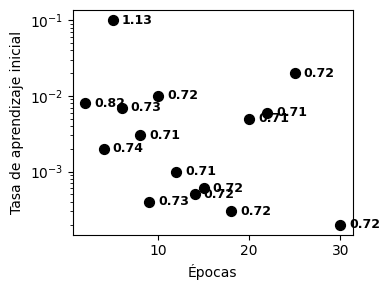

In [61]:
# Graficar campo escalar interpolado
plt.figure(figsize=(4, 3))
#contour = plt.contourf(X, Y, Z_interp, levels=100, cmap='viridis', extend='both')
#plt.colorbar(contour, label='Puntaje Interpolado')
plt.scatter(known_points[:, 0], known_points[:, 1], color='black', edgecolor='black', s=50, label='Puntos conocidos', zorder=10)
# Mostrar los valores en texto junto a cada punto
for (x, y, z) in zip(known_points[:, 0], known_points[:, 1], known_values):
    plt.text(x+1, y, f'{z:.2f}', color='black', fontsize=9, va='center', ha='left', weight='bold', zorder=11)
plt.xlabel('Épocas')
plt.ylabel('Tasa de aprendizaje inicial')
#plt.title('Campo escalar de Puntaje interpolado en el dominio (Épocas, LR)')
plt.yscale('log')
plt.tight_layout()
plt.show()

## 2 - Grid Search

La grilla fina definida por los siguientes puntos:

|lri/epochs |   10  |  12   |  14   |  16   |  18   |  20   |
|-----------|-------|-------|-------|-------|-------|-------|
| 0.001     | 0.71  | 0.72  | 0.71  | 0.71  | 0.72  | 0.71  |
| 0.002     | 0.72  | 0.71  | 0.72  | 0.70  | 0.71  | 0.71  |
| 0.004     | 0.71  | 0.71  | 0.70  | 0.71  | 0.71  | 0.71  |
| 0.006     | 0.72  | 0.71  | 0.71  | 0.71  | 0.72  | 0.72  |
| 0.008     | 0.72  | 0.71  | 0.71  | 0.72  | 0.71  | 0.71  |
| 0.010     | 0.73  | 0.72  | 0.72  | 0.74  | 0.73  | 0.72  |

In [98]:
# Inicializar modelo
model = NN()
"""
hidden_size: cantidad de neuronas de cada capa oculta.
num_hidden_layers: cantidad de capas ocultas.
"""

# Mover el modelo a la GPU
model = model.to(device)

# Mover los tensores espaciales a la GPU
lons_tensor = lons_tensor.to(device)
lats_tensor = lats_tensor.to(device)

# Inicializar el almacenaje de mse para graficar
train_mses_avg = []
val_mses_avg = []

# Inicializar hiperparámetros
epochs = 20
lr_initial = 0.010
optimizer = optim.Adam(model.parameters(), lr=lr_initial)
partials_train_num_reanalysis_hours = [1488]

# Número de rentrenamientos en val
num_retrains_val = val_num_reanalysis_hours - 2

# Definir el scheduler para un Cosine Learning-Rate Schedule
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.0001)

# Cálculo de curvas de entrenamiento
for partial_train_num_reanalysis_hours in partials_train_num_reanalysis_hours:

  # Número de rentrenamientos en train
  num_retrains_train = partial_train_num_reanalysis_hours - 2
  
  print(f"Iniciando entrenamiento con {partial_train_num_reanalysis_hours} cantidad de reanálisis.")

  # Recorrer épocas
  for epoch in range(epochs):

    # Inicializar el primer reanálisis de inicio, intermedio y de fin
    ini_train = 0
    mid_train = 1
    fin_train = 2

    # ENTRENAMIENTO
    # Recorriendo los reanálisis
    for retrain in range(num_retrains_train):

      optimizer.zero_grad()

      # Separar tiempos de datos etiquetados
      u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train = separate_time(ini_train, mid_train, fin_train, u_norm_train, v_norm_train, temp_norm_train, alt_geop_norm_train)
      # Tensorizar datos etiquetados
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = tensorize_data(u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train)

      # Mover los tensores (t=0) de entrada, usados durante el entrenameinto, a device
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train = move_tensors(u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)
      u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train = move_tensors(u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = move_tensors(u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)

      # Habilitar la diferenciación automática variables espaciales
      lons_tensor.requires_grad_(True)
      lats_tensor.requires_grad_(True)
      # Habilitar la diferenciación automática variable físicas
      u_tensor_ini_train.requires_grad_(True)
      v_tensor_ini_train.requires_grad_(True)
      temp_tensor_ini_train.requires_grad_(True)
      alt_geop_tensor_ini_train.requires_grad_(True)
      u_tensor_mid_train.requires_grad_(True)
      v_tensor_mid_train.requires_grad_(True)
      temp_tensor_mid_train.requires_grad_(True)
      alt_geop_tensor_mid_train.requires_grad_(True)

      # Primera predicción del modelo sobre datos de entrenamiento
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = model(lons_tensor, lats_tensor, u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)

      # Mover los tensores (t=6) de entrada, usados durante el entrenamiento, a device
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = move_tensors(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Segunda predicción del modelo sobre datos de entrenamiento
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = model(lons_tensor, lats_tensor, u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Mover los tensores (t=12), usados durante el entrenamiento, a device
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = move_tensors(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train)

      # Cálculo de pérdidas datos etiquetados
      loss_ini_mid_datos_train = label_loss(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      loss_mid_fin_datos_train = label_loss(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)
      train_loss = loss_ini_mid_datos_train + loss_mid_fin_datos_train

      # Retropropagación
      train_loss.backward()
      optimizer.step()

      # Cambiar los siguientes reanálisis consecutivos
      ini_train += 1
      mid_train += 1
      fin_train += 1

    # Actualizar el learning rate con el scheduler
    scheduler.step()

  print(f"Finalizado entrenamiento con {partial_train_num_reanalysis_hours} cantidad de reanálisis.")

  # Evaluar en conjunto de entrenamiento y validación
  with torch.no_grad():

    # Inicializar el primer reanálisis de inicio, intermedio y de fin
    ini_train = 0
    mid_train = 1
    fin_train = 2
    ini_val = 0
    mid_val = 1
    fin_val = 2

    # ENTRENAMIENTO
    # Inicializa los mse por tamaño de conjunto de entrenamiento
    total_train_mse = 0.0

    for retrain_train in range(num_retrains_train):

      # Separar tiempos de datos etiquetados de entrenamiento
      u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train = separate_time(ini_train, mid_train, fin_train, u_norm_train, v_norm_train, temp_norm_train, alt_geop_norm_train)
      # Tensorizar datos etiquetados de entrenamiento
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = tensorize_data(u_ini_train, v_ini_train, temp_ini_train, alt_geop_ini_train, u_mid_train, v_mid_train, temp_mid_train, alt_geop_mid_train, u_fin_train, v_fin_train, temp_fin_train, alt_geop_fin_train)

      # Mover los tensores (t=0) de entrada, de entrenamiento, a device
      u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train = move_tensors(u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)
      u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train = move_tensors(u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train = move_tensors(u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)

      # Primera predicción del modelo sobre datos de entrenamiento
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = model(lons_tensor, lats_tensor, u_tensor_ini_train, v_tensor_ini_train, temp_tensor_ini_train, alt_geop_tensor_ini_train)

      # Mover los tensores (t=6) de entrada, de entrenamiento, a device
      u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train = move_tensors(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Segunda predicción del modelo sobre datos de entrenamiento
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = model(lons_tensor, lats_tensor, u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train)

      # Mover los tensores (t=12) de entrada, de entrenamiento, a device
      u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train = move_tensors(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train)

      # Cálculo de mse datos etiquetados de entrenamiento
      mse_ini_mid_datos_train = mse_calculated(u_pred_mid_train, v_pred_mid_train, temp_pred_mid_train, alt_geop_pred_mid_train, u_tensor_mid_train, v_tensor_mid_train, temp_tensor_mid_train, alt_geop_tensor_mid_train)
      mse_mid_fin_datos_train = mse_calculated(u_pred_fin_train, v_pred_fin_train, temp_pred_fin_train, alt_geop_pred_fin_train, u_tensor_fin_train, v_tensor_fin_train, temp_tensor_fin_train, alt_geop_tensor_fin_train)
      train_mse = 0.5*mse_ini_mid_datos_train + 0.5*mse_mid_fin_datos_train

      # Acumulación de mse por tamaño de conjunto de entrenamiento
      total_train_mse += train_mse.item()

      # Cambiar los siguientes reanálisis consecutivos
      ini_train += 1
      mid_train += 1
      fin_train += 1
  
    # Calcular los mse medias
    avg_train_mse = total_train_mse / partial_train_num_reanalysis_hours
    # Guardar mse para gráficas
    train_mses_avg.append(avg_train_mse)

    print(f"Average Train MSE: {avg_train_mse:.2f}")

    # VALIDACIÓN
    # Inicializa los mse por tamaño de conjunto de entrenamiento
    total_val_mse = 0.0

    for retrain_val in range(num_retrains_val):

      # Separar tiempos de datos etiquetados de validación
      u_ini_val, v_ini_val, temp_ini_val, alt_geop_ini_val, u_mid_val, v_mid_val, temp_mid_val, alt_geop_mid_val, u_fin_val, v_fin_val, temp_fin_val, alt_geop_fin_val = separate_time(ini_val, mid_val, fin_val, u_norm_val, v_norm_val, temp_norm_val, alt_geop_norm_val)
      # Tensorizar datos etiquetados de validación
      u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val, u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val, u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val = tensorize_data(u_ini_val, v_ini_val, temp_ini_val, alt_geop_ini_val, u_mid_val, v_mid_val, temp_mid_val, alt_geop_mid_val, u_fin_val, v_fin_val, temp_fin_val, alt_geop_fin_val)

      # Mover los tensores (t=0) de entrada, de validación, a device
      u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val = move_tensors(u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val)
      u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val = move_tensors(u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val)
      u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val = move_tensors(u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val)

      # Primera predicción del modelo sobre datos de validación
      u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val = model(lons_tensor, lats_tensor, u_tensor_ini_val, v_tensor_ini_val, temp_tensor_ini_val, alt_geop_tensor_ini_val)

      # Mover los tensores (t=6) de entrada, de validación, a device
      u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val = move_tensors(u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val)

      # Segunda predicción del modelo sobre datos de validación
      u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val = model(lons_tensor, lats_tensor, u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val)

      # Mover los tensores (t=12) de entrada, de validación, a device
      u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val = move_tensors(u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val)

      # Cálculo de mse datos etiquetados de validación
      mse_ini_mid_datos_val = mse_calculated(u_pred_mid_val, v_pred_mid_val, temp_pred_mid_val, alt_geop_pred_mid_val, u_tensor_mid_val, v_tensor_mid_val, temp_tensor_mid_val, alt_geop_tensor_mid_val)
      mse_mid_fin_datos_val = mse_calculated(u_pred_fin_val, v_pred_fin_val, temp_pred_fin_val, alt_geop_pred_fin_val, u_tensor_fin_val, v_tensor_fin_val, temp_tensor_fin_val, alt_geop_tensor_fin_val)
      val_mse = 0.5*mse_ini_mid_datos_val + 0.5*mse_mid_fin_datos_val

      # Acumulación de mse por tamaño de conjunto de entrenamiento
      total_val_mse += val_mse.item()

      # Cambiar los siguientes reanálisis consecutivos
      ini_val += 1
      mid_val += 1
      fin_val += 1
  
    # Calcular los mse medias
    avg_val_mse = total_val_mse / val_num_reanalysis_hours
    # Guardar mse para gráficas
    val_mses_avg.append(avg_val_mse)

    print(f"Average Val MSE: {avg_val_mse:.2f}")
    print("--"*30)

# Liberar al dispositivo
del model, optimizer, scheduler
del train_loss, total_train_mse, train_mse
del avg_train_mse, train_mses_avg
del total_val_mse, val_mse, avg_val_mse, val_mses_avg
gc.collect()
torch.cuda.empty_cache()

Iniciando entrenamiento con 1488 cantidad de reanálisis.
Finalizado entrenamiento con 1488 cantidad de reanálisis.
Average Train MSE: 0.73
Average Val MSE: 0.72
------------------------------------------------------------


In [99]:
# Armado de los datos de MSE Valdation
puntaje_11 = 0.71  # Épocas=10, LR_inicial=0.001
puntaje_12 = 0.72  # Épocas=12, LR_inicial=0.001
puntaje_13 = 0.71  # Épocas=14, LR_inicial=0.001
puntaje_14 = 0.71  # Épocas=16, LR_inicial=0.001
puntaje_15 = 0.72  # Épocas=18, LR_inicial=0.001
puntaje_16 = 0.71  # Épocas=20, LR_inicial=0.001
puntaje_21 = 0.72  # Épocas=10, LR_inicial=0.002
puntaje_22 = 0.71  # Épocas=12, LR_inicial=0.002
puntaje_23 = 0.72  # Épocas=14, LR_inicial=0.002
puntaje_24 = 0.70  # Épocas=16, LR_inicial=0.002
puntaje_25 = 0.71  # Épocas=18, LR_inicial=0.002
puntaje_26 = 0.71  # Épocas=20, LR_inicial=0.002
puntaje_31 = 0.71  # Épocas=10, LR_inicial=0.004
puntaje_32 = 0.71  # Épocas=12, LR_inicial=0.004
puntaje_33 = 0.70  # Épocas=14, LR_inicial=0.004
puntaje_34 = 0.71  # Épocas=16, LR_inicial=0.004
puntaje_35 = 0.71  # Épocas=18, LR_inicial=0.004
puntaje_36 = 0.71  # Épocas=20, LR_inicial=0.004
puntaje_41 = 0.72  # Épocas=10, LR_inicial=0.006
puntaje_42 = 0.71  # Épocas=12, LR_inicial=0.006
puntaje_43 = 0.71  # Épocas=14, LR_inicial=0.006
puntaje_44 = 0.71  # Épocas=16, LR_inicial=0.006
puntaje_45 = 0.72  # Épocas=18, LR_inicial=0.006
puntaje_46 = 0.72  # Épocas=20, LR_inicial=0.006
puntaje_51 = 0.72  # Épocas=10, LR_inicial=0.008
puntaje_52 = 0.71  # Épocas=12, LR_inicial=0.008
puntaje_53 = 0.71  # Épocas=14, LR_inicial=0.008
puntaje_54 = 0.72  # Épocas=16, LR_inicial=0.008
puntaje_55 = 0.71  # Épocas=18, LR_inicial=0.008
puntaje_56 = 0.71  # Épocas=20, LR_inicial=0.008
puntaje_61 = 0.73  # Épocas=10, LR_inicial=0.010
puntaje_62 = 0.72  # Épocas=12, LR_inicial=0.010
puntaje_63 = 0.72  # Épocas=14, LR_inicial=0.010
puntaje_64 = 0.74  # Épocas=16, LR_inicial=0.010
puntaje_65 = 0.73  # Épocas=18, LR_inicial=0.010
puntaje_66 = 0.72  # Épocas=20, LR_inicial=0.010

In [100]:
# Arma un nuevo dataframe con los resultados previos
data_metrics = pd.DataFrame([
    {'epochs': 10, 'lrinicial': 0.001,  'puntaje': puntaje_11},
    {'epochs': 12, 'lrinicial': 0.001,  'puntaje': puntaje_12},
    {'epochs': 14, 'lrinicial': 0.001,  'puntaje': puntaje_13},
    {'epochs': 16, 'lrinicial': 0.001,  'puntaje': puntaje_14},
    {'epochs': 18, 'lrinicial': 0.001,  'puntaje': puntaje_15},
    {'epochs': 20, 'lrinicial': 0.001,  'puntaje': puntaje_16},
    {'epochs': 10, 'lrinicial': 0.002,  'puntaje': puntaje_21},
    {'epochs': 12, 'lrinicial': 0.002,  'puntaje': puntaje_22},
    {'epochs': 14, 'lrinicial': 0.002,  'puntaje': puntaje_23},
    {'epochs': 16, 'lrinicial': 0.002,  'puntaje': puntaje_24},
    {'epochs': 18, 'lrinicial': 0.002,  'puntaje': puntaje_25},
    {'epochs': 20, 'lrinicial': 0.002,  'puntaje': puntaje_26},
    {'epochs': 10, 'lrinicial': 0.004,  'puntaje': puntaje_31},
    {'epochs': 12, 'lrinicial': 0.004,  'puntaje': puntaje_32},
    {'epochs': 14, 'lrinicial': 0.004,  'puntaje': puntaje_33},
    {'epochs': 16, 'lrinicial': 0.004,  'puntaje': puntaje_34},
    {'epochs': 18, 'lrinicial': 0.004,  'puntaje': puntaje_35},
    {'epochs': 20, 'lrinicial': 0.004,  'puntaje': puntaje_36},
    {'epochs': 10, 'lrinicial': 0.006,  'puntaje': puntaje_41},
    {'epochs': 12, 'lrinicial': 0.006,  'puntaje': puntaje_42},
    {'epochs': 14, 'lrinicial': 0.006,  'puntaje': puntaje_43},
    {'epochs': 16, 'lrinicial': 0.006,  'puntaje': puntaje_44},
    {'epochs': 18, 'lrinicial': 0.006,  'puntaje': puntaje_45},
    {'epochs': 20, 'lrinicial': 0.006,  'puntaje': puntaje_46},
    {'epochs': 10, 'lrinicial': 0.008,  'puntaje': puntaje_51},
    {'epochs': 12, 'lrinicial': 0.008,  'puntaje': puntaje_52},
    {'epochs': 14, 'lrinicial': 0.008,  'puntaje': puntaje_53},
    {'epochs': 16, 'lrinicial': 0.008,  'puntaje': puntaje_54},
    {'epochs': 18, 'lrinicial': 0.008,  'puntaje': puntaje_55},
    {'epochs': 20, 'lrinicial': 0.008,  'puntaje': puntaje_56},
    {'epochs': 10, 'lrinicial': 0.010,  'puntaje': puntaje_61},
    {'epochs': 12, 'lrinicial': 0.010,  'puntaje': puntaje_62},
    {'epochs': 14, 'lrinicial': 0.010,  'puntaje': puntaje_63},
    {'epochs': 16, 'lrinicial': 0.010,  'puntaje': puntaje_64},
    {'epochs': 18, 'lrinicial': 0.010,  'puntaje': puntaje_65},
    {'epochs': 20, 'lrinicial': 0.010,  'puntaje': puntaje_66},
])

In [101]:
# Convierte el DataFrame a una tabla tipo matriz
pivot_table = data_metrics.pivot_table(index='lrinicial', columns='epochs', values='puntaje', aggfunc='mean')

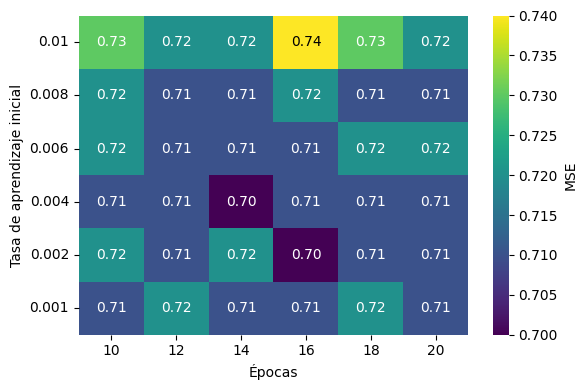

In [103]:
pivot_table_invertido = pivot_table.iloc[::-1]

plt.figure(figsize=(6, 4))
ax = sns.heatmap(pivot_table_invertido, annot=False, fmt=".2f", cmap="viridis", cbar_kws={'label': 'MSE'})

for y in range(pivot_table_invertido.shape[0]):
    for x in range(pivot_table_invertido.shape[1]):
        value = pivot_table_invertido.iloc[y, x]
        if pd.notna(value):
            ax.text(
                x + 0.5, y + 0.5,
                f"{value:.2f}",
                ha='center', va='center',
                color='white' if value < 0.74 else 'black',
                fontsize=10
            )

plt.xlabel("Épocas")
plt.ylabel("Tasa de aprendizaje inicial")
plt.xticks(ticks=np.arange(len(pivot_table.columns)) + 0.5, labels=pivot_table.columns)
# Para que las etiquetas del eje y coincidan con el orden invertido:
plt.yticks(ticks=np.arange(len(pivot_table.index)) + 0.5, labels=pivot_table.index[::-1], rotation=0)

plt.tight_layout()
plt.show()